In [1]:

from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.AutoFit import elim_addit_funcs


In [2]:
%matplotlib widget

In [3]:


sammypath = "/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy"

#%% 
# import bad cases

bad_case_dir = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/IFB_failed_cases/bad_cases_for_Noah_check"
bad_cases_ids = [190, 268, 105, 372, 127]
case_id = 372

case_filename = f'sample_{case_id}.pkl'
gen_params_filename =  f'params_gen.pkl'

# loading case
sample_data = elim_addit_funcs.load_obj_from_pkl(folder_name = bad_case_dir,
                                                     pkl_fname = case_filename )

params_loaded = elim_addit_funcs.load_obj_from_pkl(folder_name = bad_case_dir,
                                                     pkl_fname= gen_params_filename)

### define new particle pair for updated version
syndat_loaded = params_loaded
# Ta_pair_loaded = syndat_loaded.particle_pair
# Ta_pair = Ta_pair_loaded
Ta_pair = Particle_Pair()
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, 
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)


### udpate experiment template
for synmod in syndat_loaded.syndat_models:
    exp = synmod.generative_experimental_model
    filepath = os.path.realpath(f'./data/template_{exp.title}_edited_oldres')
    exp.template = os.path.realpath(filepath)


#%%
import plotting as myplot
from copy import deepcopy
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions(sammypath,
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR_2"
                                         })


options = InitialFBOPT(Gn_threshold=1e-1,
                       iterations=2,
                       max_steps = 30,
                       LevMarV0=0.1,
                       fit_all_spin_groups=False,
                       spin_group_keys = ['3.0'],
                       step_threshold=0.001,
                       starting_Gn1_multiplier = 20,
                       num_Elam=50,
                       external_resonances=False)
autofit_initial = InitialFB(options)



datasets = [val.pw_reduced for key, val in sample_data.items()]
experiments = [synmod.generative_experimental_model for synmod in syndat_loaded.syndat_models]
covariance_data = [{} for key, val in sample_data.items()]


In [4]:

outs = autofit_initial.fit(Ta_pair,
                               [202, 227],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)


	FIT 1
Initial solve from 50 resonance features

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [302156.0, 798551.0, 1013604.0, 8163.15, 12431.1, 2134905.25, 2517.5769]
1    0.15 : [111666.0, 99933.9, 61402.6, 1249.9, 1396.23, 275648.63, 325.0573]
2    0.225: [63199.3, 25478.1, 12526.7, 891.048, 983.661, 103078.809, 121.5552]
3    0.338: [3647.43, 1585.16, 1691.5, 810.597, 717.016, 8451.703, 9.9666]
4    0.506: [1572.25, 1507.26, 1676.63, 650.417, 628.912, 6035.469, 7.1173]
5    0.759: [1336.81, 594.754, 702.134, 638.379, 656.134, 3928.211, 4.6323]
6    1.139: [809.086, 617.034, 785.303, 598.584, 628.324, 3438.331, 4.0546]
7    1.709: [843.974, 459.426, 521.112, 615.849, 653.131, 3093.492, 3.648]
8    2.0  : [659.254, 483.326, 584.536, 601.942, 642.475, 2971.533, 3.5042]
9    2.0  : [684.529, 443.028, 478.526, 610.529, 656.001, 2872.613, 3.3875]
10    2.0  : [607.694, 450.165, 515.846, 609.17, 6

In [112]:
outs.sammy_outs_fit_2[-1].chi2_post

[650.429, 401.286, 419.657, 696.763, 777.649]

In [5]:

true_par = deepcopy(sample_data['trans1mm'].par_true)
true_par['varyE'] = np.ones(len(true_par))
true_par['varyGg'] = np.ones(len(true_par))
true_par['varyGn1'] = np.ones(len(true_par))

sammyINPyw = sammy_classes.SammyInputDataYW(
        particle_pair = Ta_pair,
        resonance_ladder = true_par,  

        datasets= datasets,
        experiments = experiments,
        experimental_covariance= covariance_data, 
        
        max_steps = 5,
        iterations = 2,
        step_threshold = 0.001,
        LevMar = True,
        LevMarV = 1.5,
        LevMarVd = 5,
        minF = 1e-5,
        maxF = 2.0,
        initial_parameter_uncertainty = 0.1,
        
        autoelim_threshold = None,
        LS = False,
        )

true_out = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)

# figure()
# _ = hist(np.log10(ending_parameters.Gn1), bins=50)

Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [366.358, 289.075, 273.072, 197.781, 265.178, 1391.464, 1.6409]
1    0.15 : [366.59, 285.021, 256.22, 200.446, 257.327, 1365.604, 1.6104]
2    0.225: [362.411, 291.561, 236.8, 195.295, 254.713, 1340.78, 1.5811]
3    0.338: [358.253, 288.639, 240.43, 194.985, 254.777, 1337.084, 1.5768]
4    0.506: [357.657, 291.433, 236.523, 194.418, 254.579, 1334.61, 1.5738]
Maximum steps reached


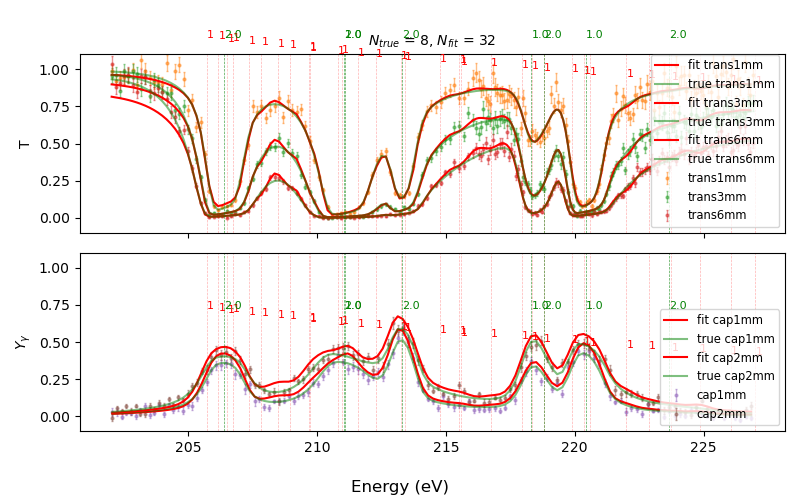

In [6]:


fig = myplot.plot_datafits(datasets,
                     experiments,
                     fits = outs.sammy_outs_fit_2[-1].pw_post,
                     fit_pars = outs.sammy_outs_fit_2[-1].par_post,
                     fig_size=(8,5),
                     true= true_out.pw_post,
                     true_pars = true_out.par_post,
                    #  priors=true_out.pw,
                    #  prior_pars=true_out.par
                     )
fig.tight_layout()

In [116]:
# np.tile([1,0], np.ceil(50/3))
outs.sammy_outs_fit_2[-1].par_post


,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,205.253402,63.909419,0.123479,1.0,1.0,1.0,1.0
1,205.387148,63.949652,0.108856,1.0,1.0,1.0,1.0
2,206.104928,68.297006,37.937750,1.0,1.0,1.0,1.0
3,206.627609,59.343620,61.917987,1.0,1.0,1.0,1.0
4,207.075979,63.112253,4.858937,1.0,1.0,1.0,1.0
5,207.631064,63.300136,2.499175,1.0,1.0,1.0,1.0
6,208.078381,63.394474,1.218748,1.0,1.0,1.0,1.0
7,208.642694,63.494307,1.430051,1.0,1.0,1.0,1.0
8,209.071763,63.704733,1.565046,1.0,1.0,1.0,1.0
9,209.624866,62.889637,3.299535,1.0,1.0,1.0,1.0


In [120]:
vary1 = np.tile([0,0,1,1], int(len(outs.sammy_outs_fit_2[-1].par_post)/4))
vary2 = np.tile([1,1,0,0], int(len(outs.sammy_outs_fit_2[-1].par_post)/4))
chi2_per_ndat = np.sum(outs.sammy_outs_fit_2[-1].chi2_post) / np.sum([len(each) for each in outs.sammy_outs_fit_2[-1].pw_post])
parameters = deepcopy(outs.sammy_outs_fit_2[-1].par_post)
tracker = 1
while chi2_per_ndat > np.sum(true_out.chi2_post)/np.sum([len(each) for each in true_out.pw_post]):

    # if tracker % 2 == 0:
    parameters['varyE'] = vary1
    parameters['varyGg'] = vary1
    parameters['varyGn1'] = vary1
    print("vary1")
    # else:
    sammyINPyw.resonance_ladder = parameters
    sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)
    chi2_per_ndat = np.sum(sammyout.chi2)/np.sum([len(each) for each in sammyout.pw_post])
    parameters = sammyout.par_post


    parameters['varyE'] = vary2
    parameters['varyGg'] = vary2
    parameters['varyGn1'] = vary2
    print("vary2")
    sammyINPyw.resonance_ladder = parameters
    sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)
    chi2_per_ndat = np.sum(sammyout.chi2)/np.sum([len(each) for each in sammyout.pw_post])
    parameters = sammyout.par_post

    tracker += 1
    if tracker > 10:
        break
    # if chi2_per_ndat >= chi2_per_ndat_next:
    #     break
    # chi2_per_ndat_next = chi2_per_ndat
    

vary1
Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [650.431, 401.282, 419.665, 696.761, 777.648, 2945.787, 3.4738]
Repeat step 1, 	fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
		0.1  : [663.839, 403.73, 425.492, 714.952, 795.054, 3003.067, 3.5414]
		0.02 : [652.08, 401.74, 421.49, 697.292, 778.333, 2950.935, 3.4799]
		0.004: [651.619, 401.598, 420.382, 696.278, 777.453, 2947.33, 3.4756]
		0.001: [651.463, 401.585, 420.264, 696.267, 777.444, 2947.023, 3.4753]
		0.0  : [651.464, 401.573, 420.191, 696.272, 777.449, 2946.949, 3.4752]
		0.0  : [651.477, 401.584, 420.201, 696.26, 777.444, 2946.966, 3.4752]
		0.0  : [651.467, 401.579, 420.258, 696.266, 777.438, 2947.008, 3.4752]
1    0.0  : [651.467, 401.579, 420.258, 696.266, 777.438, 2947.008, 3.4752]
Fudge below minimum value, taking solution 0
vary2
Stepping until convergence
chi2 values
step fudge: ['trans1m

In [119]:
chi2_per_ndat

3.4738054245283023

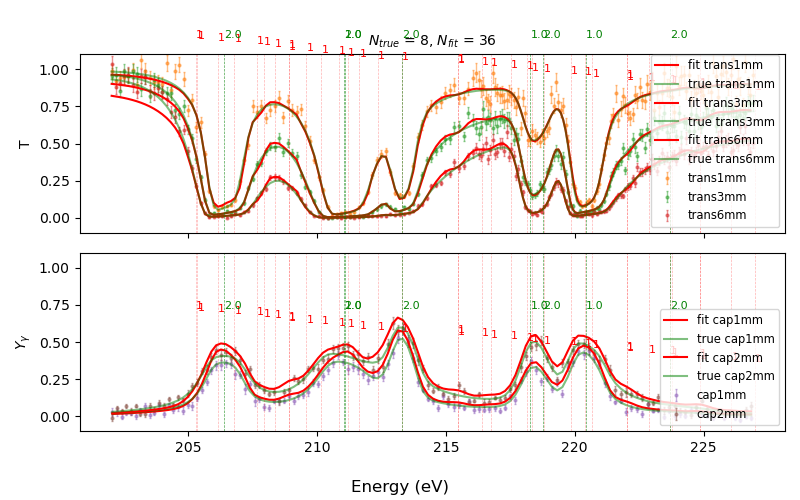

In [121]:
# figure()
# _ = hist(np.log10(sammyout.par_post.Gn1), bins=50)

fig = myplot.plot_datafits(datasets,
                     experiments,
                     fits = sammyout.pw_post,
                     fit_pars = sammyout.par_post,
                     fig_size=(8,5),
                     true=true_out.pw_post,
                     true_pars = true_out.par_post)
fig.tight_layout()

In [122]:
final_1 = deepcopy(sammyout)

In [123]:
vary1 = np.tile([0,0,0,1,1,1], int(len(final_1.par_post)/6))
vary2 = np.tile([1,1,1,0,0,0], int(len(final_1.par_post)/6))
chi2_per_ndat = np.sum(final_1.chi2_post) / np.sum([len(each) for each in final_1.pw_post])
parameters = deepcopy(final_1.par_post)
tracker = 1
while chi2_per_ndat > np.sum(true_out.chi2_post)/np.sum([len(each) for each in true_out.pw_post]):

    # if tracker % 2 == 0:
    parameters['varyE'] = vary1
    parameters['varyGg'] = vary1
    parameters['varyGn1'] = vary1
    print("vary1")
    # else:
    sammyINPyw.resonance_ladder = parameters
    sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)
    chi2_per_ndat = np.sum(sammyout.chi2)/np.sum([len(each) for each in sammyout.pw_post])
    parameters = sammyout.par_post


    parameters['varyE'] = vary2
    parameters['varyGg'] = vary2
    parameters['varyGn1'] = vary2
    print("vary2")
    sammyINPyw.resonance_ladder = parameters
    sammyout = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)
    chi2_per_ndat = np.sum(sammyout.chi2)/np.sum([len(each) for each in sammyout.pw_post])
    parameters = sammyout.par_post

    tracker += 1
    if tracker > 10:
        break
    # if chi2_per_ndat >= chi2_per_ndat_next:
    #     break
    # chi2_per_ndat_next = chi2_per_ndat
    

vary1
Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [380.805, 309.777, 359.77, 232.953, 333.533, 1616.838, 1.9066]
1    0.15 : [380.468, 310.138, 359.578, 232.635, 333.431, 1616.25, 1.906]
Chi2 improvement below threshold
vary2
Stepping until convergence
chi2 values
step fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
0    0.1  : [380.474, 310.139, 359.577, 232.635, 333.431, 1616.256, 1.906]
Repeat step 1, 	fudge: ['trans1mm', 'trans3mm', 'trans6mm', 'cap1mm', 'cap2mm', 'sum', 'sum/ndat']
		0.1  : [381.56, 307.697, 376.168, 231.684, 332.845, 1629.954, 1.9221]
		0.02 : [379.936, 309.669, 360.162, 233.566, 335.913, 1619.246, 1.9095]
		0.004: [380.263, 308.539, 364.144, 234.143, 333.281, 1620.37, 1.9108]
		0.001: [381.053, 309.945, 360.594, 233.885, 334.414, 1619.891, 1.9102]
		0.0  : [380.095, 309.398, 360.445, 233.938, 335.797, 1619.673, 1.91]
		0.0  : [380.312